# Data I/O

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt

rankings = pd.read_csv(r'/Users/hyunjinjeong/Documents/jupyter/fifa_ranking_with_olymipc_medals.csv')
rankings = rankings.loc[:,['rank', 'country_full', 'country_abrv', 'rank_date', 'accumulate_gold', 'accumulate_silver',
                           'accumulate_bronze', 'accumulate_forth']]
rankings = rankings.replace({"IR Iran": "Iran", "Côte d'Ivoire" : "Ivory Coast" })
rankings['rank_date'] = pd.to_datetime(rankings['rank_date'])

matches = pd.read_csv(r'/Users/hyunjinjeong/Documents/jupyter/results.csv')
matches =  matches.replace({'Germany DR': 'Germany', 'China': 'China PR'})
matches['date'] = pd.to_datetime(matches['date'])

olympic = pd.read_csv(r'/Users/hyunjinjeong/Documents/jupyter/Olympic_2020 Dataset.csv')
olympic = olympic.loc[:, ['Team', 'Group', 'First match against', 'Second match against', 'Third match against', 'Advance to 8']]
olympic = olympic.dropna(how='all')
olympic = olympic.replace({"IRAN": "Iran", "Costarica": "Costa Rica", "Porugal": "Portugal", 
                               "Columbia": "Colombia", "Korea" : "Korea Republic"})
olympic = olympic.set_index('Team')

# Feature extraction

In [2]:
#메달에 따른 가산점 추가 
rankings['medal_points'] = (rankings['accumulate_gold']*4)+(rankings['accumulate_silver']*3)+\
                           (rankings['accumulate_bronze']*2)+rankings['accumulate_forth']


In [3]:
#matches와 merge하기 위해 rankings를 시계열 데이터로 늘이기
rankings = rankings.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()



In [4]:
# rankings와 join
matches = matches.merge(rankings, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])
matches = matches.merge(rankings, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))

#매치 merge에 대응하기 위한 시계열 데이터로 정렬

In [5]:
matches

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,...,medal_points_home,rank_date_away,rank_away,country_full_away,country_abrv_away,accumulate_gold_away,accumulate_silver_away,accumulate_bronze_away,accumulate_forth_away,medal_points_away
0,1993-01-01,Ghana,Mali,1,1,Friendly,Libreville,Gabon,True,1993-01-01,...,2.0,1993-01-01,69.0,Mali,MLI,0.0,0.0,0.0,0.0,0.0
1,1993-01-02,Gabon,Burkina Faso,1,1,Friendly,Libreville,Gabon,False,1993-01-02,...,0.0,1993-01-02,97.0,Burkina Faso,BFA,0.0,0.0,0.0,0.0,0.0
2,1993-01-02,Kuwait,Lebanon,2,0,Friendly,Kuwait City,Kuwait,False,1993-01-02,...,0.0,1993-01-02,161.0,Lebanon,LBN,0.0,0.0,0.0,0.0,0.0
3,1993-01-03,Burkina Faso,Mali,1,0,Friendly,Libreville,Gabon,True,1993-01-03,...,0.0,1993-01-03,69.0,Mali,MLI,0.0,0.0,0.0,0.0,0.0
4,1993-01-03,Gabon,Ghana,2,3,Friendly,Libreville,Gabon,False,1993-01-03,...,0.0,1993-01-03,39.0,Ghana,GHA,0.0,0.0,1.0,0.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20536,2021-05-24,Iraq,Tajikistan,0,0,Friendly,Basra,Iraq,False,2021-05-24,...,1.0,2021-05-24,121.0,Tajikistan,TJK,0.0,0.0,0.0,0.0,0.0
20537,2021-05-24,United Arab Emirates,Jordan,5,1,Friendly,Dubai,United Arab Emirates,False,2021-05-24,...,0.0,2021-05-24,95.0,Jordan,JOR,0.0,0.0,0.0,0.0,0.0
20538,2021-05-25,Indonesia,Afghanistan,2,3,Friendly,Dubai,United Arab Emirates,True,2021-05-25,...,0.0,2021-05-25,149.0,Afghanistan,AFG,0.0,0.0,0.0,0.0,0.0
20539,2021-05-25,Oman,Thailand,1,0,Friendly,Dubai,United Arab Emirates,True,2021-05-25,...,0.0,2021-05-25,106.0,Thailand,THA,0.0,0.0,0.0,0.0,0.0


In [6]:
#feature 추가
matches['rank_difference'] = matches['rank_home'] - matches['rank_away']
matches['average_rank'] = (matches['rank_home'] + matches['rank_away'])/2
matches['score_difference'] = matches['home_score'] - matches['away_score']
matches['medal_difference'] = matches['medal_points_home'] - matches['medal_points_away']
matches['is_won'] = matches['score_difference'] > 0 #무승부는 패배 판정
matches['is_stake'] = matches['tournament'] != 'Friendly'

#올림픽 참가 여부 추가
matches['op_participant'] = matches['home_team'] * matches['home_team'].isin(olympic.index.tolist())
matches['op_participant'] = matches['op_participant'].replace({'':'Other'})
matches = matches.join(pd.get_dummies(matches['op_participant']))

In [7]:
matches

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral,rank_date_home,...,Honduras,Ivory Coast,Japan,Mexico,New Zealand,Other,Romania,Saudi Arabia,South Africa,Spain
0,1993-01-01,Ghana,Mali,1,1,Friendly,Libreville,Gabon,True,1993-01-01,...,0,0,0,0,0,1,0,0,0,0
1,1993-01-02,Gabon,Burkina Faso,1,1,Friendly,Libreville,Gabon,False,1993-01-02,...,0,0,0,0,0,1,0,0,0,0
2,1993-01-02,Kuwait,Lebanon,2,0,Friendly,Kuwait City,Kuwait,False,1993-01-02,...,0,0,0,0,0,1,0,0,0,0
3,1993-01-03,Burkina Faso,Mali,1,0,Friendly,Libreville,Gabon,True,1993-01-03,...,0,0,0,0,0,1,0,0,0,0
4,1993-01-03,Gabon,Ghana,2,3,Friendly,Libreville,Gabon,False,1993-01-03,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20536,2021-05-24,Iraq,Tajikistan,0,0,Friendly,Basra,Iraq,False,2021-05-24,...,0,0,0,0,0,1,0,0,0,0
20537,2021-05-24,United Arab Emirates,Jordan,5,1,Friendly,Dubai,United Arab Emirates,False,2021-05-24,...,0,0,0,0,0,1,0,0,0,0
20538,2021-05-25,Indonesia,Afghanistan,2,3,Friendly,Dubai,United Arab Emirates,True,2021-05-25,...,0,0,0,0,0,1,0,0,0,0
20539,2021-05-25,Oman,Thailand,1,0,Friendly,Dubai,United Arab Emirates,True,2021-05-25,...,0,0,0,0,0,1,0,0,0,0


# Modeling

In [8]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

X, y = matches.loc[:,['average_rank', 'rank_difference', 'medal_difference', 'is_stake' ]], matches['is_won']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logreg = linear_model.LogisticRegression(C=1e-5) #강도를 낮춰주는 파라미터, C값이 낮을수록 계수를 0으로 근사하므로 정규화가 강화된다.
features = PolynomialFeatures(degree=2)

model = Pipeline([  #서로 다른 매개변수를 설정하면서 함께 교차로 검증할 수 있는 단계를 종합
    ('polynomial_features', features),
    ('logistic_regression', logreg)])

model = model.fit(X_train, y_train)

/Users/hyunjinjeong/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


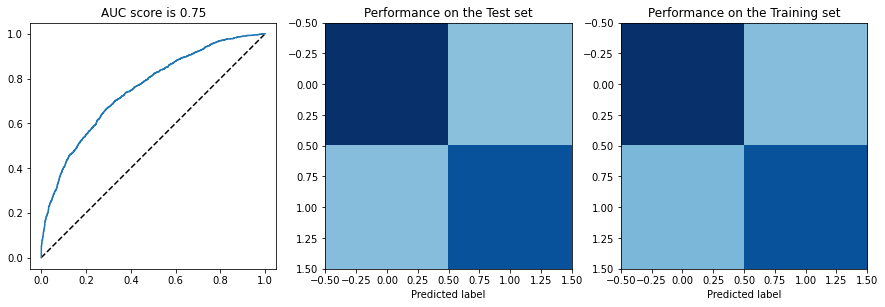

In [9]:
# figures 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')
pass

#위의 파란 곡선 아래 면적의 넓이를 AUC 라고 하는데
#실제 양성을 양성으로 잘 예측한 경우가 많으면(민감도가 높을수록) 
#좋은 모델(그래프의 왼쪽 위)이라고 할 수 있습니다.

#True 영역이 진할수록 정확도가 높다

Stakes distribution in the wrong predictions
True     0.55832
False    0.44168
Name: is_stake, dtype: float64
Stakes distribution overall
True     0.634244
False    0.365756
Name: is_stake, dtype: float64


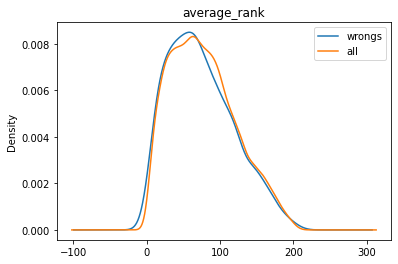

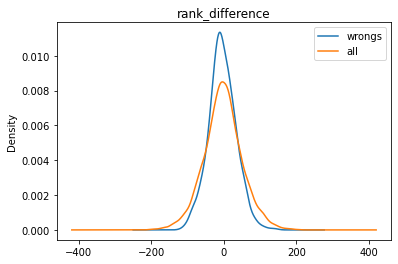

In [10]:
features = ['average_rank', 'rank_difference']
wrongs = y_test != model.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde() #KDE : 커널 밀도 추정
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])
    
print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_stake'].value_counts() / X.shape[0])

#랭크 차이가 많이 안나오는 팀은 오답 확률이 더 나올 수 있다는 것을 보여준다.
#0~100에서 avarage_rank가 치우쳐있을 때에도 오답이 나올 확률이 더 높은 걸 보여준다는 그래프

# simulation

## Group rounds

In [11]:
margin = 0.05

olympic_rankings = rankings.loc[(rankings['rank_date'] == rankings['rank_date'].max()) &
                                rankings['country_full'].isin(olympic.index.unique()) ]
olympic_rankings = olympic_rankings.set_index(['country_full'])

#Home Team Advantage(개최국에 2배 가중치)
olympic_rankings.loc[['Japan'],['medal_points']] = olympic_rankings.loc[['Japan'],['medal_points']]*2

#가장 최근 랭킹에서 올림픽에 참가하는 팀 선별

In [12]:
olympic_rankings

,rank_date,rank,country_abrv,accumulate_gold,accumulate_silver,accumulate_bronze,accumulate_forth,medal_points
country_full,,,,,,,,
Argentina,2021-05-27,8.0,ARG,2.0,2.0,0.0,0.0,14.0
Australia,2021-05-27,41.0,AUS,0.0,0.0,0.0,1.0,1.0
Brazil,2021-05-27,3.0,BRA,1.0,3.0,2.0,1.0,18.0
Egypt,2021-05-27,46.0,EGY,0.0,0.0,0.0,2.0,2.0
France,2021-05-27,2.0,FRA,1.0,1.0,0.0,0.0,7.0
Germany,2021-05-27,12.0,GER,0.0,1.0,2.0,1.0,8.0
Honduras,2021-05-27,67.0,HON,0.0,0.0,0.0,1.0,1.0
Ivory Coast,2021-05-27,59.0,CIV,0.0,0.0,0.0,0.0,0.0
Japan,2021-05-27,28.0,JPN,0.0,0.0,1.0,1.0,6.0


In [13]:
from itertools import combinations

opponents = ['First match against', 'Second match against', 'Third match against']

olympic['points'] = 0
olympic['total_prob'] = 0

for group in sorted(set(olympic['Group'])):
    print('---Group {}---'.format(group))
    for home, away in combinations(olympic.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = olympic_rankings.loc[home, 'rank']
        home_points = olympic_rankings.loc[home, 'medal_points']
        opp_rank = olympic_rankings.loc[away, 'rank']
        opp_points = olympic_rankings.loc[away, 'medal_points']

        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['medal_difference'] = home_points - opp_points

        home_win_prob = model.predict_proba(row)[:,1][0] #일렬로 세로로 세운다?
        olympic.loc[home, 'total_prob'] += home_win_prob
        olympic.loc[away, 'total_prob'] += 1-home_win_prob
        
        points = 0
        
        if home_win_prob <= 0.5 - margin:
            print('\033[31m' + "{} Wins with {:.2f}".format(away, 1-home_win_prob) + '\033[0m')
            olympic.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            olympic.loc[home, 'points'] += 3
            print('\033[31m' + "{} Wins with {:.2f}".format(home, home_win_prob) + '\033[0m')
        if points == 1:
            print('\033[31m' + "Draw" + '\033[0m')
            olympic.loc[home, 'points'] += 1
            olympic.loc[away, 'points'] += 1
    
    print("\n")

---Group A---
Mexico vs. France: France Wins with 0.56
Mexico vs. South Africa: Mexico Wins with 0.79
Mexico vs. Japan: Mexico Wins with 0.57
France vs. South Africa: France Wins with 0.81
France vs. Japan: France Wins with 0.62
South Africa vs. Japan: Japan Wins with 0.82


---Group B---
Korea Republic vs. Honduras: Korea Republic Wins with 0.62
Korea Republic vs. New Zealand: Korea Republic Wins with 0.85
Korea Republic vs. Romania: Draw
Honduras vs. New Zealand: Honduras Wins with 0.75
Honduras vs. Romania: Romania Wins with 0.64
New Zealand vs. Romania: Romania Wins with 0.85


---Group C---
Spain vs. Australia: Spain Wins with 0.65
Spain vs. Egypt: Spain Wins with 0.68
Spain vs. Argentina: Draw
Australia vs. Egypt: Draw
Australia vs. Argentina: Argentina Wins with 0.81
Egypt vs. Argentina: Argentina Wins with 0.83


---Group D---
Ivory Coast vs. Brazil: Brazil Wins with 0.93
Ivory Coast vs. Germany: Germany Wins with 0.82
Ivory Coast vs. Saudi Arabia: Draw
Brazil vs. Germany: Draw

## Single-elimination rounds

In [ ]:
"""pairing = [0,3,4,7,2,5,1,6]

olympic = olympic.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_olympic = olympic.groupby('Group').nth([0, 1]) # select the top 2
next_round_olympic = next_round_olympic.reset_index()
next_round_olympic = next_round_olympic.loc[pairing]
next_round_olympic = next_round_olympic.set_index('Team')"""

In [14]:
#대진 순 8강 진출 팀 입력
next_round_olympic = olympic.loc[olympic['Advance to 8'].isnull() == False]
next_round_olympic = next_round_olympic.reset_index()
next_round_olympic

,Team,Group,First match against,Second match against,Third match against,Advance to 8,points,total_prob
0,Mexico,A,France,Japan,South Africa,Y,6,1.793164
1,Japan,A,South Africa,Mexico,France,Y,3,1.635610
2,Korea Republic,B,New Zealand,Romania,Honduras,Y,7,1.971487
3,New Zealand,B,Korea Republic,Honduras,Romania,Y,0,0.548857
4,Spain,C,Egypt,Australia,Argentina,Y,7,1.822281
5,Egypt,C,Spain,Argentina,Australia,Y,1,1.012835
6,Ivory Coast,D,Saudi Arabia,Brazil,Germany,Y,1,0.734709
7,Brazil,D,Germany,Ivory Coast,Saudi Arabia,Y,7,2.161336


In [16]:
#8강 대진 순서
pairing = [0, 2, 7, 5, 1, 3, 4, 6]

next_round_olympic = next_round_olympic.loc[pairing]
next_round_olympic = next_round_olympic.set_index('Team')

In [17]:
finals = ['Round_of_8', 'Semifinal', 'Third_Place_Match', 'Final']

next_round_olympic_ = next_round_olympic
third_place_match = []
labels = []
odds = []
medals = []

for f in finals:
    print('---{}---'.format(f))
    iterations = int(len(next_round_olympic_) / 2)
    winners = []

    for i in range(iterations):
        if f == 'Third_Place_Match':
            home, away = third_place_match[0], third_place_match[1]
        else:
            home, away = next_round_olympic_.index[i*2], next_round_olympic_.index[i*2+1]
        
        print("{} vs. {}: ".format(home,away), end='')
        
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = olympic_rankings.loc[home, 'rank']
        home_points = olympic_rankings.loc[home, 'medal_points']
        opp_rank = olympic_rankings.loc[away, 'rank']
        opp_points = olympic_rankings.loc[away, 'medal_points']
        
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['medal_difference'] = home_points - opp_points
        home_win_prob = model.predict_proba(row)[:,1][0]
 
        if model.predict_proba(row)[:,1] <= 0.5:
            print('\033[31m' + "{0} Wins with {1:.2f}".format(away, 1-home_win_prob) + '\033[0m')
            win, lose = away, home
        else:
            print('\033[31m' + "{0} Wins with {1:.2f}".format(home, home_win_prob) + '\033[0m')
            win, lose = home, away
        
        # 다음 경기 진출팀, 3위 결정전 진출팀, 메달 결정
        if f == 'Semifinal':
            third_place_match.append(lose) # 준결승전이면 패자를 3위 결정전 진출팀으로 추가
        if f != 'Third_Place_Match':
            winners.append(win) # 3위 결정전을 제외한 모든 경기는 승자를 winners에 추가
        else:
            medals.append(win) # Bronze
        if f == 'Final':
            medals.append(lose) # Sliver
            medals.append(win) # Gold

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(olympic_rankings.loc[home, 'country_abrv'], 1/home_win_prob,
                                                         olympic_rankings.loc[away, 'country_abrv'], 1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
               
    if f != 'Third_Place_Match': # 3위 결정전일때는 next_round_olympic에 승자를 반영하지 않음
        next_round_olympic_ = next_round_olympic_.loc[winners]
        
    print("\n")

print ("Gold   : {}\nSilver : {}\nBronze : {}".format(medals[2], medals[1], medals[0]))

---Round_of_8---
Mexico vs. Korea Republic: Mexico Wins with 0.63
Brazil vs. Egypt: Brazil Wins with 0.64
Japan vs. New Zealand: Japan Wins with 0.89
Spain vs. Ivory Coast: Spain Wins with 0.73


---Semifinal---
Mexico vs. Brazil: Brazil Wins with 0.65
Japan vs. Spain: Spain Wins with 0.65


---Third_Place_Match---
Mexico vs. Japan: Mexico Wins with 0.57


---Final---
Brazil vs. Spain: Spain Wins with 0.51


Gold   : Spain
Silver : Brazil
Bronze : Mexico


# Visualization 

In [18]:
labels

['MEX(1.59) vs. KOR(2.70)',
 'BRA(1.56) vs. EGY(2.78)',
 'JPN(1.12) vs. NZL(9.05)',
 'ESP(1.36) vs. CIV(3.75)',
 'MEX(2.86) vs. BRA(1.54)',
 'JPN(2.89) vs. ESP(1.53)',
 'MEX(1.77) vs. JPN(2.30)',
 'BRA(2.02) vs. ESP(1.98)']

In [19]:
del odds[-2]
del labels[-2]

In [20]:
labels

['MEX(1.59) vs. KOR(2.70)',
 'BRA(1.56) vs. EGY(2.78)',
 'JPN(1.12) vs. NZL(9.05)',
 'ESP(1.36) vs. CIV(3.75)',
 'MEX(2.86) vs. BRA(1.54)',
 'JPN(2.89) vs. ESP(1.53)',
 'BRA(2.02) vs. ESP(1.98)']

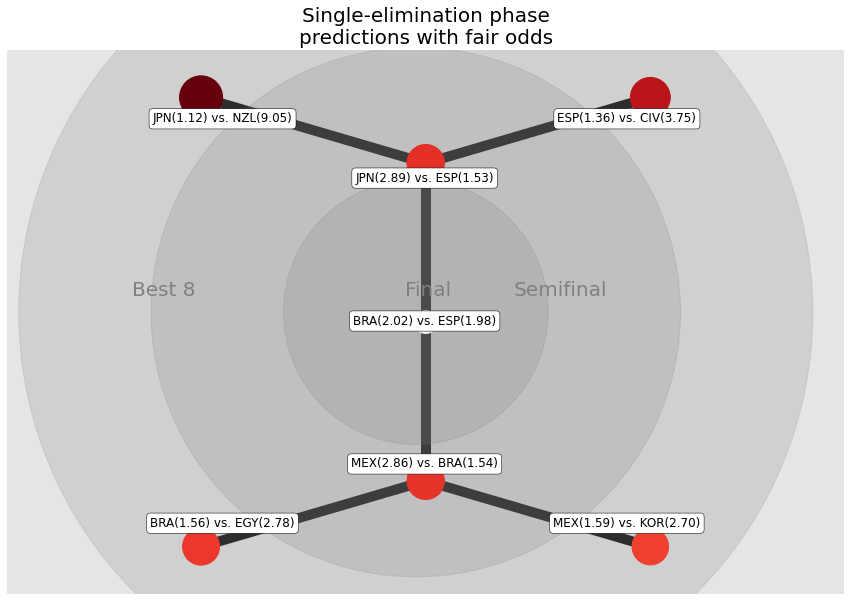

In [21]:
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

node_sizes = pd.DataFrame(list(reversed(odds)))
scale_factor = 0.3 # for visualization
G = nx.balanced_tree(2,2)
pos = graphviz_layout(G, prog='twopi')
centre = pd.DataFrame(pos).mean(axis=1).mean()

plt.figure(figsize=(15, 10))
ax = plt.subplot(1,1,1)
# add circles 
circle_positions = [(235, 'black'), (180, 'blue'), (120, 'red'), (60, 'yellow')]
[ax.add_artist(plt.Circle((centre, centre), 
                          cp, color='grey', 
                          alpha=0.2)) for cp, c in circle_positions]

# draw first the graph
nx.draw(G, pos, 
        node_color=node_sizes.diff(axis=1)[1].abs().pow(scale_factor), 
        node_size=node_sizes.diff(axis=1)[1].abs().pow(scale_factor)*2000, 
        alpha=1, 
        cmap='Reds',
        edge_color='black',
        width=10,
        with_labels=False)

# draw the custom node labels
shifted_pos = {k:[(v[0]-centre)*0.9+centre,(v[1]-centre)*0.9+centre] for k,v in pos.items()}
nx.draw_networkx_labels(G, 
                        pos=shifted_pos, 
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=dict(zip(reversed(range(len(labels))), labels)))

texts = ((10, 'Best 8', 'blue'), (190, 'Semifinal', 'red'), (130, 'Final', 'yellow'))
[plt.text(p, centre+10, t, 
          fontsize=20, color='grey', 
          va='center', ha='center') for p,t,c in texts]
plt.axis('equal')
plt.title('Single-elimination phase\npredictions with fair odds', fontsize=20)
plt.show()

Text(0.5, 1.0, 'Total prob by teams')

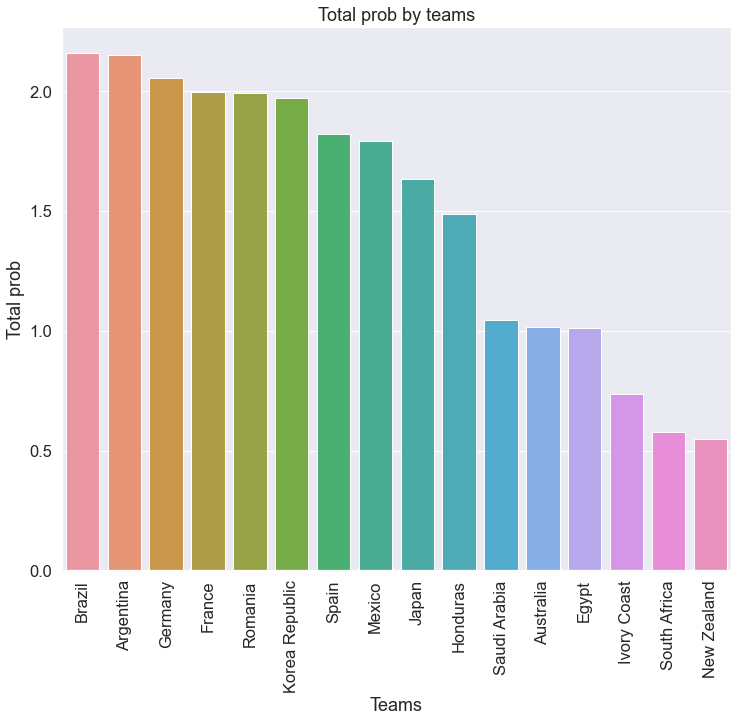

In [22]:
import seaborn as sns

# Plotting total goal attempts by teams
attempts= olympic.groupby('Team')['total_prob'].sum().reset_index().sort_values(by=('total_prob'),ascending=False)

plt.figure(figsize = (12, 10), facecolor = None)
sns.set_style("darkgrid")
sns.set(font_scale=1.5)
plot1 = sns.barplot(x="Team", y="total_prob", data=attempts)

plot1.set_xticklabels(attempts['Team'], rotation=90, ha="center")
plot1.set(xlabel='Teams',ylabel='Total prob')
plot1.set_title('Total prob by teams')

In [23]:
olympic

,Group,First match against,Second match against,Third match against,Advance to 8,points,total_prob
Team,,,,,,,
Mexico,A,France,Japan,South Africa,Y,6,1.793164
France,A,Mexico,South Africa,Japan,NaN,9,1.995025
South Africa,A,Japan,France,Mexico,NaN,0,0.576202
Japan,A,South Africa,Mexico,France,Y,3,1.635610
Korea Republic,B,New Zealand,Romania,Honduras,Y,7,1.971487
Honduras,B,Romania,New Zealand,Korea Republic,NaN,3,1.486428
New Zealand,B,Korea Republic,Honduras,Romania,Y,0,0.548857
Romania,B,Honduras,Korea Republic,New Zealand,NaN,7,1.993228
Spain,C,Egypt,Australia,Argentina,Y,7,1.822281


Text(0, 0.5, 'Teams')

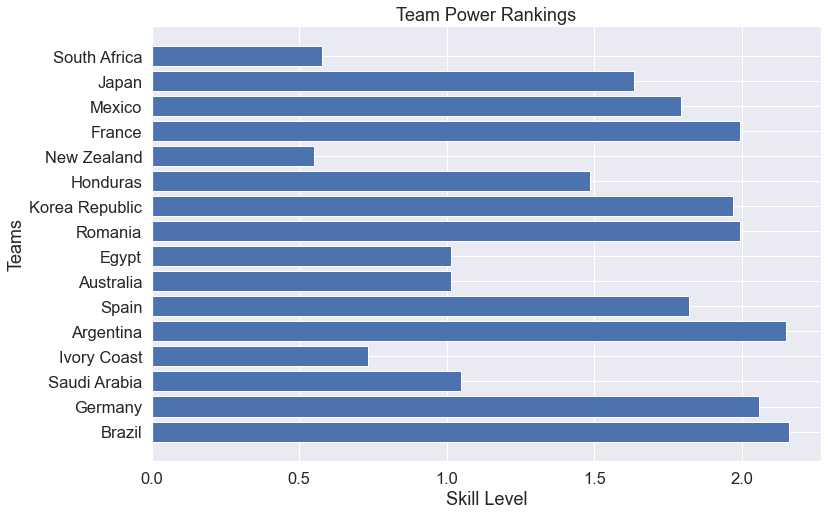

In [24]:
olympic = olympic.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()

vis_team = olympic['Team']
vis_prob = olympic['total_prob']

plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (12,8)

plt.figure()
plt.barh(vis_team, vis_prob)


plt.title('Team Power Rankings')
plt.xlabel('Skill Level')
plt.ylabel('Teams')

Text(0, 0.5, 'Teams')

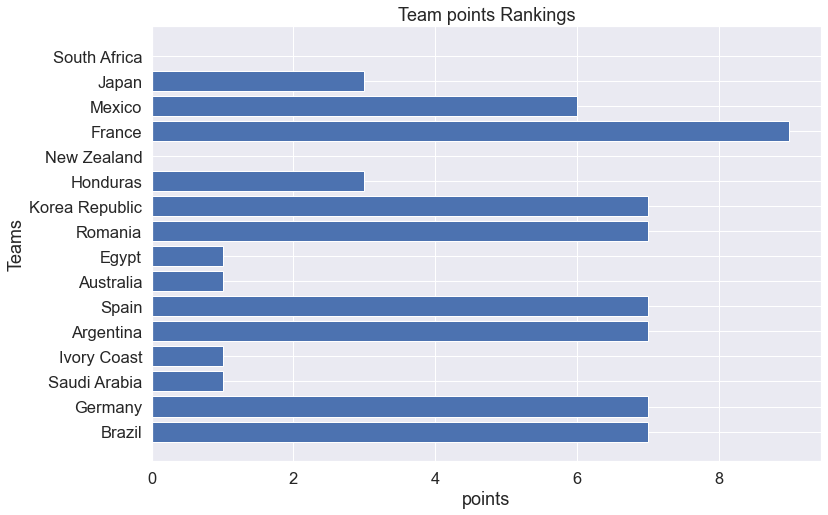

In [25]:
vis_team = olympic['Team']
vis_points = olympic['points']

plt.rcParams["font.size"] = 12
plt.rcParams["figure.figsize"] = (12,8)

plt.figure()
plt.barh(vis_team, vis_points)


plt.title('Team points Rankings')
plt.xlabel('points')
plt.ylabel('Teams')

그룹별로 total_prob 나타내기

In [26]:
four_group = ['A', 'B', 'C', 'D']
for group in four_group:
  df = olympic[olympic['Group'] == group]
  df

A group total_prob


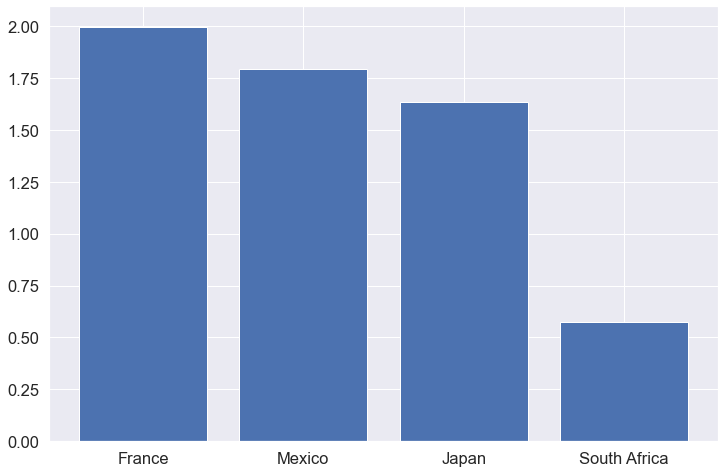

B group total_prob


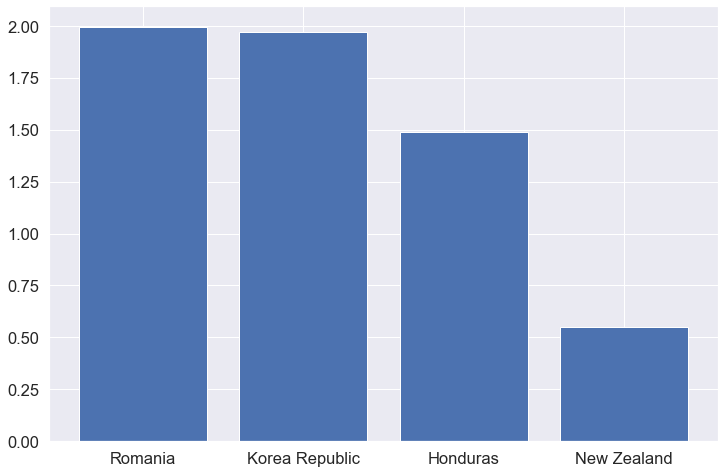

C group total_prob


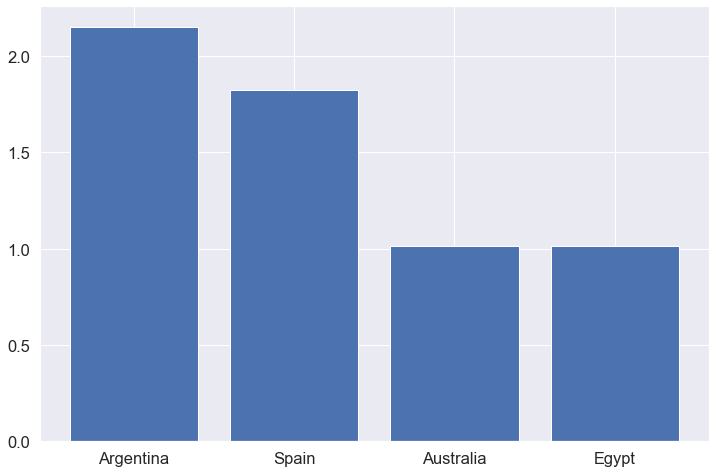

D group total_prob


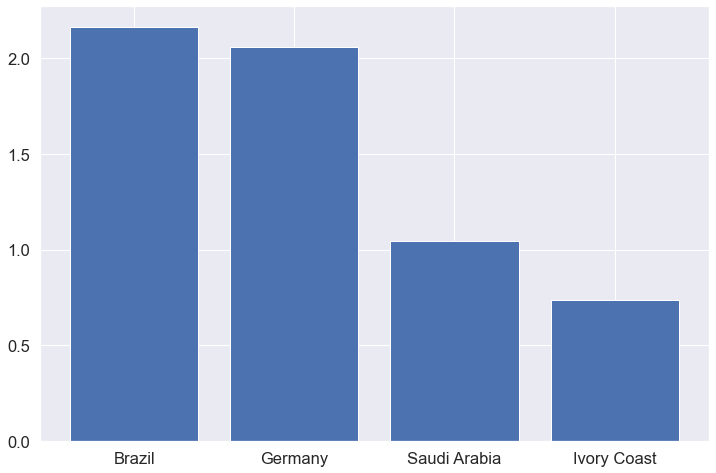

In [27]:
four_group = ['A', 'B', 'C', 'D']
for i in range(4):
  df = olympic[olympic['Group'] == four_group[i]]
  print('{} group total_prob'.format(four_group[i]))
  ratio = df['total_prob']
  labels = df['Team']
  plt.bar(labels,ratio)
  plt.show()